In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

## Loading Data

In [ ]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train.shape, type(X_train), X_train.dtype

((60000, 28, 28), numpy.ndarray, dtype('uint8'))

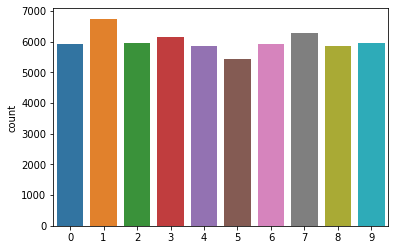

In [ ]:
sns.countplot(x=y_train)
plt.show()

In [ ]:
np.isnan(X_train).any()

False

In [ ]:
np.isnan(X_test).any()

False

## Visualizing MNIST data

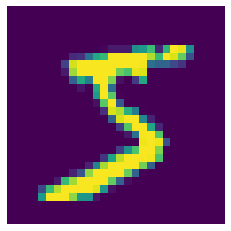

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(X_train[0])
plt.axis('off')
plt.show()

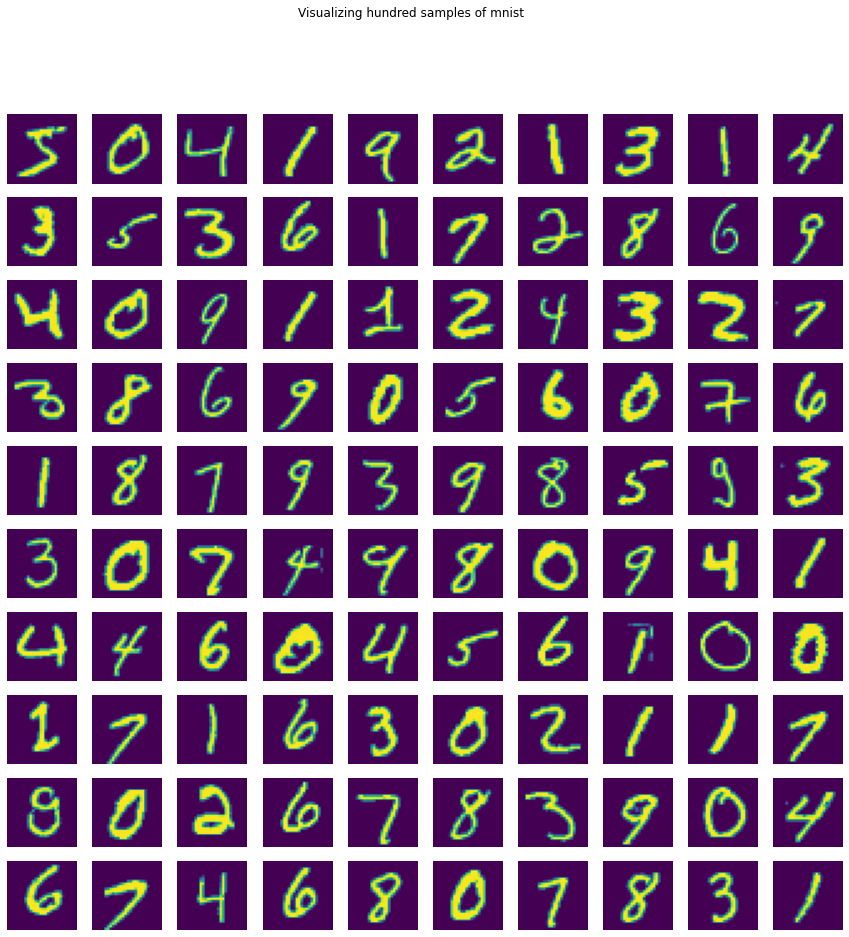

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(15, 15))
fig.suptitle('Visualizing hundred samples of mnist')

k = 0
for i in range(10):
  for j in range(10):
    axs[i, j].imshow(X_train[k])
    axs[i, j].axis('off')
    k=k+1

## Reshaping Data

In [ ]:
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32')/255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32')/255

In [ ]:
X_train.shape, type(X_train), X_train.dtype

((60000, 28, 28, 1), numpy.ndarray, dtype('float32'))

## Creating Validation Set

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Training Model

### Using Model Subclassing

In [ ]:
class MNIST_Model(tf.keras.Model):
  def __init__(self):
    super().__init__()

    self.first_cnn = tf.keras.layers.Conv2D(32, 3, activation='relu', name='first_cnn')
    self.first_pooling = tf.keras.layers.MaxPooling2D(3, 1, name='first_pooling')
    
    self.second_cnn = tf.keras.layers.Conv2D(64, 3, activation='relu', name='second_cnn')
    self.second_pooling = tf.keras.layers.MaxPooling2D(3, 1, name='second_pooling')

    self.third_cnn = tf.keras.layers.Conv2D(128, 3, activation='relu', name='third_cnn')
    self.third_pooling = tf.keras.layers.MaxPooling2D(3, 2, name='third_pooling')

    self.fourth_cnn = tf.keras.layers.Conv2D(256, 3, activation='relu', name='fourth_cnn')
    self.flatten = tf.keras.layers.Flatten(name='flatten')

    self.mixing_layer = tf.keras.layers.Dense(2048, activation='relu', name='mixing_layer')
    self.dropout = tf.keras.layers.Dropout(0.5, name='dropout')
    self.outputs = tf.keras.layers.Dense(10, activation='softmax', name='output')

  def call(self, inputs):
    x = self.first_cnn(inputs)
    x = self.first_pooling(x)
    x = self.second_cnn(x)
    x = self.second_pooling(x)
    x = self.third_cnn(x)
    x = self.third_pooling(x)
    x = self.fourth_cnn(x)
    x = self.flatten(x)
    x = self.mixing_layer(x)
    x = self.dropout(x)
    outputs = self.outputs(x)

    return outputs

  def get_model(self):
    x = tf.keras.Input(shape=(28, 28, 1))
    return tf.keras.Model(inputs=x, outputs=self.call(x), name='mnist_model')

mnist_model = MNIST_Model().get_model()

In [ ]:
mnist_model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 first_cnn (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 first_pooling (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 second_cnn (Conv2D)         (None, 22, 22, 64)        18496     
                                                                 
 second_pooling (MaxPooling2  (None, 20, 20, 64)       0         
 D)                                                              
                                                                 
 third_cnn (Conv2D)          (None, 18, 18, 128)       

In [ ]:
mnist_model.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
callbacks = [
             tf.keras.callbacks.ModelCheckpoint('mnist_model.keras', save_best_only=True),
             tf.keras.callbacks.EarlyStopping(patience=20),
]

In [ ]:
history = mnist_model.fit(X_train, y_train, 128, 40, callbacks=callbacks, validation_data=(X_val, y_val))

Epoch 1/40
375/375 [==============================] - 23s 24ms/step - loss: 0.1972 - accuracy: 0.9394 - val_loss: 0.0634 - val_accuracy: 0.9787
Epoch 2/40
375/375 [==============================] - 9s 24ms/step - loss: 0.0552 - accuracy: 0.9826 - val_loss: 0.0363 - val_accuracy: 0.9883
Epoch 3/40
375/375 [==============================] - 9s 25ms/step - loss: 0.0406 - accuracy: 0.9873 - val_loss: 0.0384 - val_accuracy: 0.9881
Epoch 4/40
375/375 [==============================] - 9s 24ms/step - loss: 0.0332 - accuracy: 0.9895 - val_loss: 0.0390 - val_accuracy: 0.9888
Epoch 5/40
375/375 [==============================] - 9s 23ms/step - loss: 0.0261 - accuracy: 0.9914 - val_loss: 0.0349 - val_accuracy: 0.9901
Epoch 6/40
375/375 [==============================] - 9s 23ms/step - loss: 0.0218 - accuracy: 0.9932 - val_loss: 0.0316 - val_accuracy: 0.9894
Epoch 7/40
375/375 [==============================] - 9s 24ms/step - loss: 0.0198 - accuracy: 0.9937 - val_loss: 0.0353 - val_accuracy: 0.990

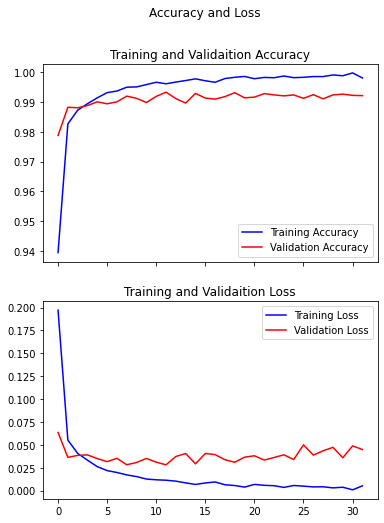

In [ ]:
def plot_loss_and_accuracy(history):
  fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 8))
  fig.suptitle('Accuracy and Loss')

  ax1.plot(history.history['accuracy'], 'b', label='Training Accuracy')
  ax1.plot(history.history['val_accuracy'], 'r', label='Validation Accuracy')
  ax1.title.set_text('Training and Validaition Accuracy')
  ax1.legend()

  ax2.plot(history.history['loss'], 'b', label='Training Loss')
  ax2.plot(history.history['val_loss'], 'r', label='Validation Loss')
  ax2.title.set_text('Training and Validaition Loss')
  ax2.legend()

plot_loss_and_accuracy(history)

In [ ]:
best_model = tf.keras.models.load_model('mnist_model.keras')
test_loss, test_acc = best_model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 0.0227 - accuracy: 0.9933


In [ ]:
print(f'Test Accuracy: {test_acc*100:.2f}')

Test Accuracy: 99.33


Achieved an accuracy of 99.33% on test set

### Predicting

In [ ]:
y_pred = best_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
mask = y_pred != y_test
wrong_pred = X_test[mask].reshape(-1, 28, 28)

In [ ]:
wrong_pred.shape

(67, 28, 28)

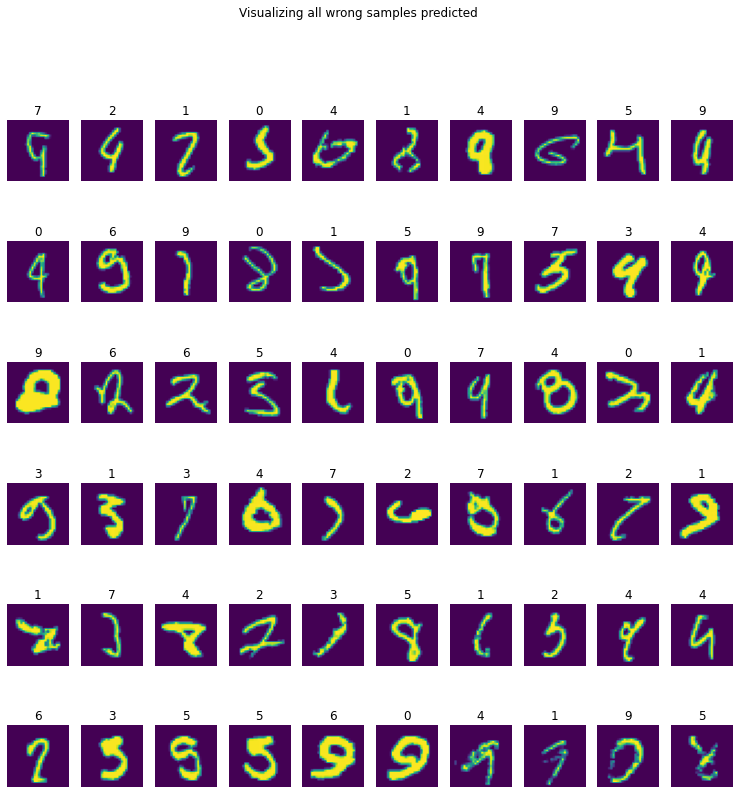

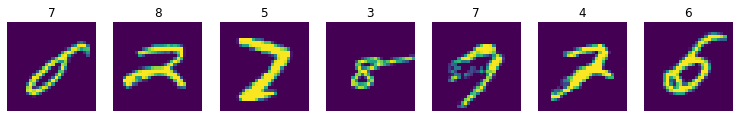

In [ ]:
fig, axs = plt.subplots(wrong_pred.shape[0]//10, 10, figsize=(13, 13))
fig.suptitle('Visualizing all wrong samples predicted')

k = 0
for i in range(len(wrong_pred)//10):
    for j in range(10):
        axs[i, j].imshow(wrong_pred[k])
        axs[i, j].axis('off')
        axs[i, j].set_title(y_pred[k])
        k=k+1
plt.show()

fig, axs = plt.subplots(1, len(wrong_pred)-k, figsize=(13, 13))
j=0
while k<len(wrong_pred):
    axs[j].imshow(wrong_pred[k])
    axs[j].axis('off')
    axs[j].set_title(y_pred[k])
    j=j+1
    k=k+1

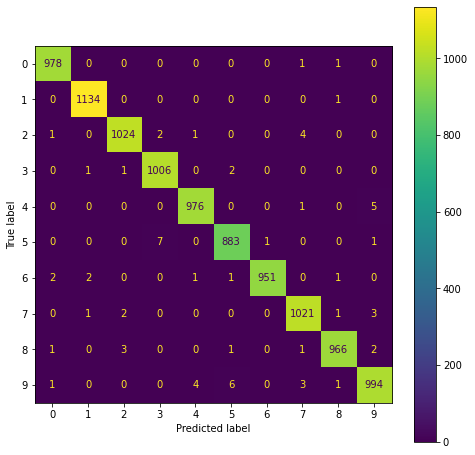

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
plt.show()